# Final Project

For the following project, you will be working with a movie dataset. The dataset is [here](https://drive.google.com/file/d/1R53inu8Jcb9GGoyiuVnBMVnO7XvCaJAE/view?usp=drive_link). The dataset columns are as follows:

* Title: The movie's title
* Genre: The movie's genre
* Stars: The number of famous actors in the movie
* Runtime: The length of the movie's runtime
* Budget: How much was spent on filming the movie (in millions)
* Promo: How much money was spent promoting the movie (in millions)
* Season: The season in which the movie was released
* Rating: The movie's rating
* R1: Reviewer 1's review
* R1: Reviewer 2's review
* R1: Reviewer 3's review

And the target variable:

* Success: Whether the film was a success or a flop

Fill in the answers to questions in the text field, and show your code below.

# Shiva Sharma 117912678

# Data loading

Load the data

In [1]:
import pandas as pd
import numpy as np
from flair.data import Sentence
from flair.models import TextClassifier

df = pd.read_csv('./CMSC320FinalProjectData.csv')

# Data Cleaning

List the three biggest data errors below, with a summary of how you fixed them and why you choose that method:


* **Some columns contain empty values, duplicate values, or incorrect values that don't make sense in the context of that column.** Particulary, runtime contains "0" values and stars contain "100" values. You can't have a movie with no runtime. You can't give a movie 100/5 stars. To fix these columns I used different forms of imputation on each. On the runtime column I imputed the replacements for the 0 values using the mode of the column values, as runtime is independant from any of the other columns so using the average makes sense. The stars column is a bit different, as we have other columns in the dataset that may point to how many stars a movie should recieve. I performed sentiment analysis on each review to calculate a sentiment score, and then imputed a row's star value by giving it whatever star value the row with the closest sentiment score and success column vlaue had.
* **Budget and Promo Data are unscaled and contain outliers.** Both columns have no standard scale for the values and seem to contain wonky large outliers. To fix this, I scaled values below a threshold to represent dollars in millions and dropped outlier values based on Inter Quartile range. This allowed the data to have a consistent and meaningful scale with no outlying values.
* **Catergorical Variables** Data contains multiple categorical columns. I fixed this by one hot encoding each of these columns. I did this because the number of unique values for each column were relatively small and one-hot encoding categorical data allows us to incorporate into our machine learning models.

In [2]:
#one-hot encode success column
df['Success'] = df['Success'].apply(lambda x : 1 if x == True else 0)

#impute entries with zero runtime 
df['Runtime'] = df['Runtime'].replace(0, df['Runtime'].mode()[0])

#drop duplicate entries
duplicates = df[df.duplicated(subset=['Title', 'Year'], keep=False)]
df = df.drop_duplicates(subset=['Title', 'Year'], keep='first')
df.dropna(inplace=True)

#impute entries with 100 stars
classifier = TextClassifier.load('en-sentiment')
# Replace R1, R2, R3 columns with binary values
for review_column in ['R1', 'R2', 'R3']:
    # Perform sentiment analysis on reviews using flair
    for index, row in df.iterrows():
        review = row[review_column]
        sentence = Sentence(review)
        classifier.predict(sentence)
        sentiment_label = sentence.labels[0].value
        binary_value = 1 if sentiment_label == 'POSITIVE' else 0
        df.at[index, review_column] = binary_value

# Create sentiment score column based on the count of positive reviews
sentiment_columns = [f'R{i}' for i in range(1, 4)]
df['Sentiment_Score'] = df[sentiment_columns].sum(axis=1)

# Standardize the Sentiment_Score using z-score
mean_sentiment = df['Sentiment_Score'].mean()
std_sentiment = df['Sentiment_Score'].std()
df['Standardized_Sentiment'] = (df['Sentiment_Score'] - mean_sentiment) / std_sentiment

# Impute the Stars column based on standardized sentiment score and success
for index, row in df.iterrows():
    stars_value = row['Stars']
    
    # Check if the Stars value is outside the range 0 to 5
    if stars_value < 0 or stars_value > 5:
        standardized_sentiment = row['Standardized_Sentiment']
        success_value = row['Success']

        similar_rows = df[(df['Standardized_Sentiment'] == standardized_sentiment) & (df['Success'] == success_value)]

        if not similar_rows.empty:
            median_stars = similar_rows['Stars'].median()
            df.at[index, 'Stars'] = median_stars
        else:
            # If no rows with the same standardized sentiment score, use the row with the closest sentiment score
            closest_row = df.loc[df['Standardized_Sentiment'].sub(standardized_sentiment).abs().idxmin()]
            df.at[index, 'Stars'] = closest_row['Stars']

# One-hot encode Genre, Season, Rating
genre_dummies = pd.get_dummies(df['Genre'], prefix='Genre')
season_dummies = pd.get_dummies(df['Season'], prefix='Season')
rating_dummies = pd.get_dummies(df['Rating'], prefix='Rating')

# Concatenate the one-hot encoded columns to the original DataFrame
df = pd.concat([df, genre_dummies, season_dummies, rating_dummies], axis=1)

# Drop the original categorical columns
#df = df.drop(['Genre', 'Season', 'Rating'], axis=1)

# Scale 'Budget' and 'Promo'
df['Budget'] = df['Budget'].apply(lambda x: x / 1e6 if x > 1000 else x)
df['Promo'] = df['Promo'].apply(lambda x: x / 1e6 if x > 1000 else x)

# Function to remove outliers based on IQR
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return data

# Remove outliers for 'Budget'
df = remove_outliers(df, 'Budget')
# Remove outliers for 'Promo'
df = remove_outliers(df, 'Promo')




# Data Exploration





Does Season have a stastically significant impact on a movie's success?

**p-value:** 0.03646643455256725, The relationship between Season and Success is statistically significant using the standard significance value of 0.5

In [3]:
from scipy.stats import chi2_contingency

observed_data = pd.crosstab(df['Season'], df['Success'])

chi2, p, _, _ = chi2_contingency(observed_data)

print(f"P-value: {p}")

alpha = 0.05 
if p < alpha:
    print("The relationship between Season and Success is statistically significant.")
else:
    print("There is no statistically significant relationship between Season and Success.")

P-value: 0.03646643455256725
The relationship between Season and Success is statistically significant.


Do seasons have a statistically significant difference in their distribution of content ratings?

**p-value:** .06864552647460724, There is no statistically significant difference in the distribution of content ratings across seasons.

In [4]:
contingency_table_ratings = pd.crosstab(df['Rating'], df['Season'])

chi2_ratings, p_value_ratings, _, _ = chi2_contingency(contingency_table_ratings)

print(f"P-value: {p_value_ratings}")

alpha = 0.05 
if p_value_ratings < alpha:
    print("There is a statistically significant difference in the distribution of content ratings across seasons.")
else:
    print("There is no statistically significant difference in the distribution of content ratings across seasons.")

P-value: 0.06864552647460724
There is no statistically significant difference in the distribution of content ratings across seasons.


Who is the harshest critic (highest precent of negative reviews)?

**Critic:** 1

In [5]:
harshest_critic = 0
harshest_rate = 0
for i in range (1,4):
  neg_reviews_percent = 1 - (df[f'R{i}'].sum() / len(df[f'R{i}']))
  if neg_reviews_percent > harshest_rate:
    harshest_rate = neg_reviews_percent
    harshest_critic = i

print(f'Harshest Critic is Critic {harshest_critic}')


Harshest Critic is Critic 1


What is the covariance between promotional budget and the filming budget?

**Cov:** 1031.779920613536

In [6]:
covariance = df[['Promo', 'Budget']].cov().iloc[0,1]
print(covariance)

1031.779920613536


# Data Visualization

Create a chart that compares the distribution of the budget for each different number of stars. (It does not need to be particularly appealing.

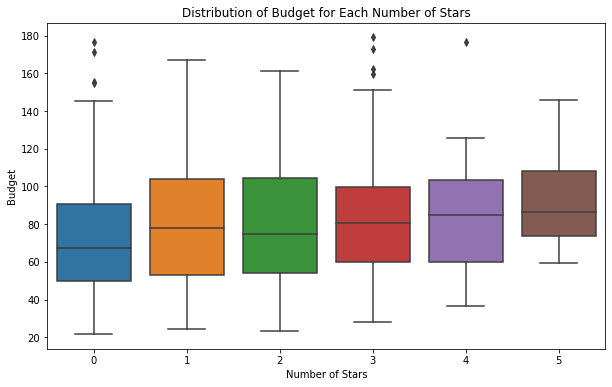

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Stars', y='Budget', data=df)

plt.xlabel('Number of Stars')
plt.ylabel('Budget')
plt.title('Distribution of Budget for Each Number of Stars')

plt.show()

Create a graph showing the average movie budget over time.

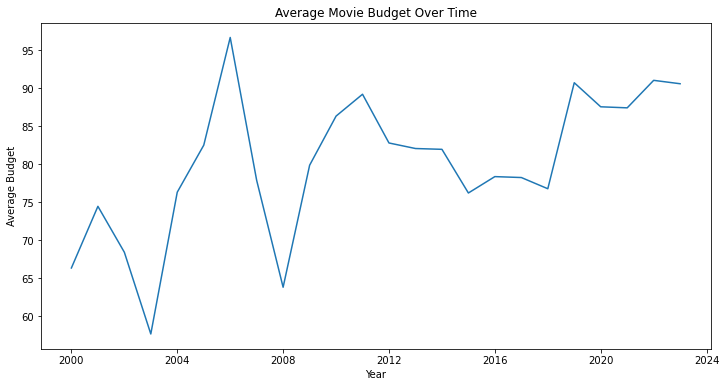

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df['Year'] = pd.to_datetime(df['Year'], format='%Y')

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Budget', data=df.groupby('Year')['Budget'].mean().reset_index())

plt.xlabel('Year')
plt.ylabel('Average Budget')
plt.title('Average Movie Budget Over Time')

plt.show()


# Feature Engineering

List any features you choose to create (if you are creating many features based on one column, you do not need to list them separately.) You are not required to create any features if you do not wish to. You may create any number of additional features.


* One-Hot Encoded categorical columns (season,rating,genere,success)
* Performed sentiment analysis on Ratings to change them into binary values (0 for negative sentiment, 1 for positive sentitment)
* Created new cloumn called Sentiment_Score to represent the average sentiment score across ratings and standardized it.

# Modeling

Create a model of your choice.

**Model type choosen:** Random Forest Classifier

# Testing

Shuffle your data and break it into a 10% test set and 90% training set. Show your model's accuracy on the test set. In order to get full credit, the model's accuracy must be higher than 50%.

**Model accuracy:** 0.9411764705882353 -> 94.11764705882353 %

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

df['Year'] = df['Year'].astype(int)

features = ['Runtime', 'Stars', 'Year', 'Budget', 'Promo',
            'R1', 'R2', 'R3', 'Sentiment_Score', 'Standardized_Sentiment',
            'Genre_Action', 'Genre_Drama', 'Genre_Fantasy', 'Genre_Romantic Comedy',
            'Genre_Science fiction', 'Season_Fall', 'Season_Spring',
            'Season_Summer', 'Season_Winter', 'Rating_PG', 'Rating_PG13', 'Rating_R']

target = 'Success'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

model_accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", model_accuracy)


Model Accuracy: 0.9411764705882353


Show the confusion matrix for your model. To get full credit, the percent of false negatives and the percent of false positives must be under 30%. (Divide false negatives by total, and divide false positives by total, and make sure both numbers are under 30%).


**False negative rate:** 5.88235294117647%

**False positive rate:** 0.0%

In [10]:
from sklearn.metrics import confusion_matrix

y_pred = rf_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

total_samples = len(y_test)

percent_false_negatives = (false_negatives / total_samples) * 100
percent_false_positives = (false_positives / total_samples) * 100

print("Confusion Matrix:")
print(conf_matrix)

print("Percent of False Negatives:", percent_false_negatives)
print("Percent of False Positives:", percent_false_positives)

Confusion Matrix:
[[40  0]
 [ 3  8]]
Percent of False Negatives: 5.88235294117647
Percent of False Positives: 0.0


What was the most important feature for your model? Don't guess, either look up how to check or do your own tests.

**Most important feature:** R1


In [11]:
feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                   Feature  Importance
5                       R1    0.405536
4                    Promo    0.074685
1                    Stars    0.072749
3                   Budget    0.072325
9   Standardized_Sentiment    0.071760
0                  Runtime    0.066778
8          Sentiment_Score    0.060272
2                     Year    0.036129
6                       R2    0.025880
7                       R3    0.025549
10            Genre_Action    0.015419
21                Rating_R    0.010793
19               Rating_PG    0.009036
17           Season_Summer    0.008625
15             Season_Fall    0.007718
16           Season_Spring    0.007186
11             Genre_Drama    0.007141
20             Rating_PG13    0.007117
18           Season_Winter    0.005555
13   Genre_Romantic Comedy    0.004955
14   Genre_Science fiction    0.003070
12           Genre_Fantasy    0.001719
